Label index : 3 | Classe : nonagon


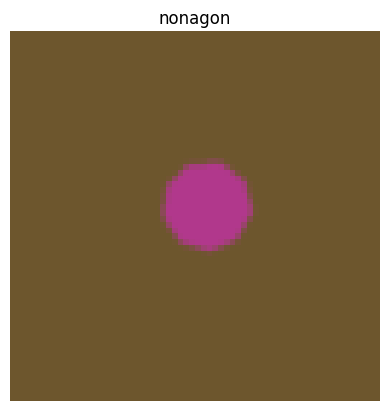

Epoch 1/10: 100%|██████████| 1125/1125 [03:19<00:00,  5.64it/s, loss=1.5678]


Epoch 1: Loss=1.8596 | Test Acc=0.3924


Epoch 2/10: 100%|██████████| 1125/1125 [03:57<00:00,  4.74it/s, loss=1.4413]


Epoch 2: Loss=1.4532 | Test Acc=0.5038


Epoch 3/10: 100%|██████████| 1125/1125 [03:36<00:00,  5.20it/s, loss=1.1426]


Epoch 3: Loss=1.2571 | Test Acc=0.5706


Epoch 4/10: 100%|██████████| 1125/1125 [03:48<00:00,  4.91it/s, loss=1.3050]


Epoch 4: Loss=1.1066 | Test Acc=0.6352


Epoch 5/10: 100%|██████████| 1125/1125 [03:54<00:00,  4.81it/s, loss=0.8515]


Epoch 5: Loss=0.9761 | Test Acc=0.6877


Epoch 6/10: 100%|██████████| 1125/1125 [03:30<00:00,  5.35it/s, loss=0.7468]


Epoch 6: Loss=0.8553 | Test Acc=0.7278


Epoch 7/10: 100%|██████████| 1125/1125 [03:21<00:00,  5.59it/s, loss=0.8226]


Epoch 7: Loss=0.7522 | Test Acc=0.7437


Epoch 8/10: 100%|██████████| 1125/1125 [03:29<00:00,  5.38it/s, loss=0.6703]


Epoch 8: Loss=0.6795 | Test Acc=0.7924


Epoch 9/10: 100%|██████████| 1125/1125 [03:35<00:00,  5.23it/s, loss=0.5330]


Epoch 9: Loss=0.6199 | Test Acc=0.7971


Epoch 10/10: 100%|██████████| 1125/1125 [03:36<00:00,  5.20it/s, loss=0.4631]


Epoch 10: Loss=0.5707 | Test Acc=0.8006


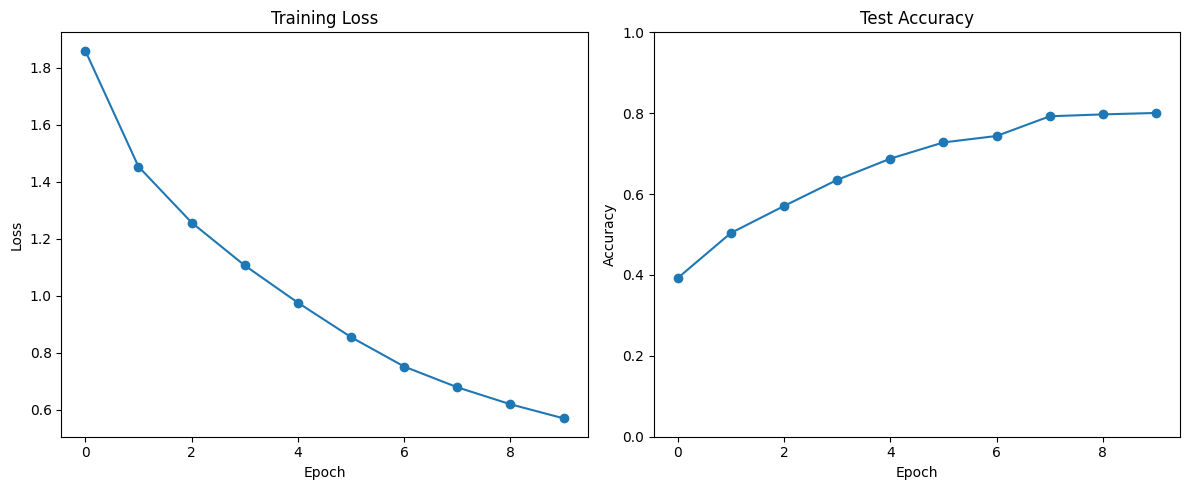

Export ONNX terminé : shapescnn.onnx


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

DATASET_DIR = "2d-shapes-dataset"
IMG_SIZE = 64
BATCH_SIZE = 64
EPOCHS = 10
CLASSES = ['circle', 'heptagon', 'hexagon', 'nonagon', 'octagon', 'pentagon', 'square', 'star', 'triangle']

class ShapesDataset(Dataset):
    def __init__(self, root, transform=None):
        self.samples = []
        self.labels = []
        self.transform = transform
        for fname in os.listdir(root):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                self.samples.append(os.path.join(root, fname))
                found = False
                for idx, label in enumerate(CLASSES):
                    if label in fname.lower():
                        self.labels.append(idx)
                        found = True
                        break
                if not found:
                    raise ValueError(f"Classe introuvable dans le nom de fichier : {fname}")
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        img = Image.open(self.samples[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = ShapesDataset(DATASET_DIR, transform=transform)
n = len(dataset)
train_size = int(0.8 * n)
test_size = n - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class ShapesCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * (IMG_SIZE//4) * (IMG_SIZE//4), 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, len(CLASSES))
        )
    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ShapesCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

train_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for X, y in progress:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress.set_postfix({"loss": f"{loss.item():.4f}"})
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            correct += (pred.argmax(1) == y).sum().item()
            total += y.size(0)
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    test_accuracies.append(epoch_acc)

model.eval()
dummy = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)
torch.onnx.export(
    model, dummy, "shapescnn.onnx",
    input_names=["input"], output_names=["output"], opset_version=13
)
